# EOEPCA+ Use Case: NO2 Tropospheric Content Cloud Filtering - Register Input Data

![end2end_workflow](img/end2end_workflow.png)

`micromamba create -n eoepca_end2end -c conda-forge pystac pystac-client odc odc-stac openeo xarray rioxarray rasterio geopandas pyproj numpy folium shapely pyjwt pip jupyterlab`

In [1]:
from pystac_client import Client
from odc.stac import stac_load
from pystac import Collection, Catalog, Extent, SpatialExtent, TemporalExtent
from datetime import datetime
import openeo

# for workspace management
import requests
import jwt
import time
import boto3
import os

## Cloud Fraction

Get cloud fraction data from the DLR GeoService STAC API.
- S5P Cloud Fraction Inpuls L3: EOC Geoservice Sentinel-5P TROPOMI L3 Daily Composites - Cloud Fraction (CF)
- https://geoservice.dlr.de/eoc/ogc/stac/v1/collections/S5P_TROPOMI_L3_P1D_CF

### Request

In [ ]:
url = "https://geoservice.dlr.de/eoc/ogc/stac/v1/"
catalog = Client.open(url)

In [3]:
collection_id = "S5P_TROPOMI_L3_P1D_CF"
bbox = [-10.0, 35.0, 30.0, 70.0]  # Europe
date_time = "2023-08-01T00:00:00Z/2023-12-31T23:59:59Z"

In [4]:
search = catalog.search(
    collections=[collection_id],
    bbox=bbox,
    datetime=date_time,
    limit=400  # adjust as needed
)

In [5]:
items = list(search.items())

### Check Data
Load the data and check that it's valid.

In [6]:
ds = stac_load(
    items,
    #bands=["CF"], 
    crs="EPSG:4326",
    resolution=0.1,
    bbox=bbox,
    chunks={"time": 1} 
)


In [7]:
monthly_mean_cf = ds['cf'].groupby('time.month').median(dim='time')

/dss/dsshome1/06/di38laz/micromamba/envs/eoepca_end2end/lib/python3.11/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


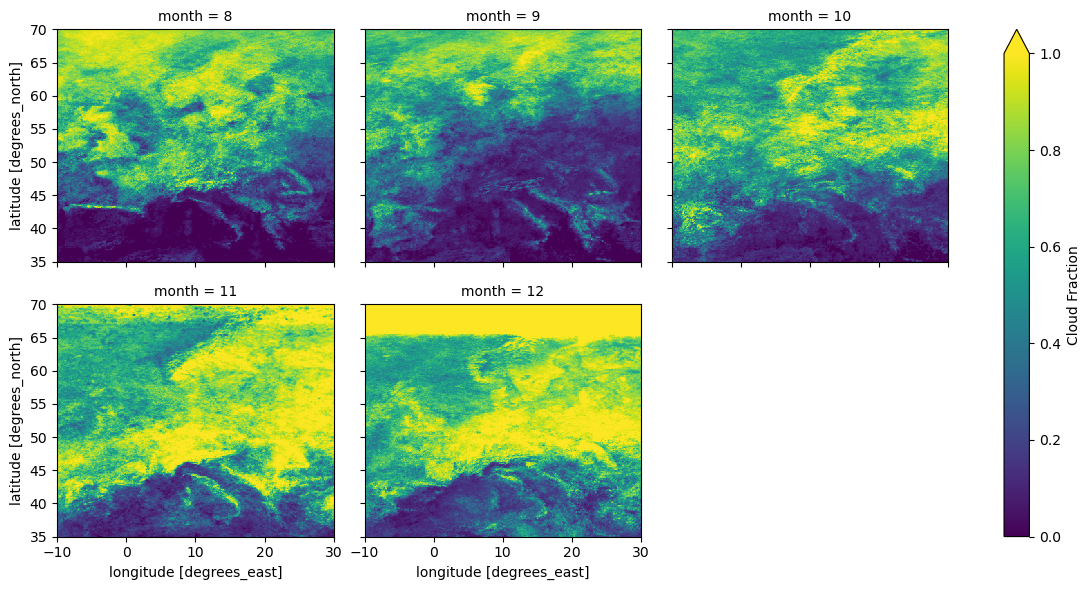

In [8]:
monthly_mean_cf.plot(col="month",
    col_wrap=3,
    cmap="viridis",
    vmin=0,
    vmax=1,
    figsize=(12, 6),
    cbar_kwargs={"label": "Cloud Fraction"})

### Register to EOEPCA via Registration BB

For registration in EOEPCA create a catalogue and collection from these items.

In [9]:
print(len(items))
print(items[0])
print(items[-1])

153
<Item id=S5P_DLR_NRTI_01_040201_L3_CF_20231231>
<Item id=S5P_DLR_NRTI_01_040100_L3_CF_20230801>


**To Do DataCubeAccess BB**: Adapt itmes to best practices. Best Practice document WIP available [here](https://github.com/EOEPCA/datacube-access/blob/main/best_practices/stac_best_practices.md).

In [10]:
items[0].stac_extensions

['https://stac-extensions.github.io/eo/v1.1.0/schema.json',
 'https://stac-extensions.github.io/view/v1.0.0/schema.json',
 'https://stac-extensions.github.io/projection/v2.0.0/schema.json',
 'https://stac-extensions.github.io/processing/v1.0.0/schema.json',
 'https://stac-extensions.github.io/scientific/v1.0.0/schema.json']

Items into Collection

and 

**To Do DataCubeAccess BB:** Adapt Collection to best practices

In [ ]:
#example of some necessary adaptions...
#item_dates = [item.datetime for item in items]
item_dates = [item.datetime for item in items if isinstance(item.datetime, datetime)]
start = min(item_dates)
end = max(item_dates)
temp_extent = TemporalExtent([[start, end]])
req_bbox = SpatialExtent([bbox])
ori_bbox = SpatialExtent([items[0].bbox])
extent = Extent(spatial=ori_bbox, temporal=temp_extent)
extensions = items[0].stac_extensions

collection = Collection(
    id="s5p-cloud-fraction-2023-aug-dec",
    description="Subset of Sentinel-5P Cloud Fraction L3 data for August-December 2023, from DLR Geoservice STAC API.",
    extent=extent,
    license="proprietary",
    keywords=["Sentinel-5P", "TROPOMI", "Cloud Fraction", "Europe", "DLR"],
    providers=[],
    summaries={},
    #stac_extensions=[extensions]
)


Collections into Catalogue

In [14]:
catalog = Catalog(
    id="s5p-cloud-fraction-europe",
    description="Catalog of Sentinel-5P L3 Cloud Fraction data August-December 2023)"
)

# Link the collection to the catalog
catalog.add_child(collection)

# Add all items to the collection
for item in items:
    collection.add_item(item)

In [15]:
catalog

<Catalog id=s5p-cloud-fraction-europe>

**To Do Workspace BB**: Save json to Workspace BB or devcluster object storage.

In [12]:
# get this info from here: https://workspace-api.apx.develop.eoepca.org/workspaces/ws-eric, can also be retrieved programatically by following example "05 Workspace Management"
owner = "eric"
password = "changeme"
ws_name = "ws-eric"

# is this info really needed?
realm = "eoepca"
base_domain = "apx.develop.eoepca.org"
keycloak_endpoint = f"https://iam-auth.{base_domain}"
workspace_api_endpoint = f'https://workspace-api.{base_domain}/workspaces'
token_endpoint = f"{keycloak_endpoint}/realms/{realm}/protocol/openid-connect/token"
minio_endpoint = "https://minio.develop.eoepca.org"

In [29]:
# do these functions need to be defined for only using the workspace?
def iam_token(username, password):
    headers = {
        "Cache-Control": "no-cache",
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {
        "scope": "roles",
        "grant_type": "password",
        "username": username,
        "password": password,
        "client_id": "demo",
        "client_secret": "demo"
    }    
    response = requests.post(token_endpoint, headers=headers, data=data)
    if response.ok:
        return response.json()["access_token"]
    else:
        print(response)
        return None

def access_ws(ws_name, token):
    headers = {
        'Authorization': 'bearer ' + token
    }
    url = f"{workspace_api_endpoint}/{ws_name}"
    print(f"HTTP GET {url}")
    response = requests.get(url, headers=headers)
    print(response)
    #print(response.text)
    return response

In [14]:
while True:
    response = access_ws(ws_name, iam_token(owner, password))
    if response.status_code == 200:
        try:
            workspace_data = response.json()
            print(workspace_data.get("status"))
            if workspace_data.get("status") == "ready":
                break
        except ValueError:
            print("not ready yet")

    print("...")
    time.sleep(20)    

HTTP GET https://workspace-api.apx.develop.eoepca.org/workspaces/ws-eric
<Response [200]>
ready


In [17]:
jwt.decode(iam_token(owner, password), options={"verify_signature": False})

{'exp': 1750143736,
 'iat': 1750143436,
 'jti': 'f04be9d3-4a65-4b3b-8aad-6c424e681fe8',
 'iss': 'https://iam-auth.apx.develop.eoepca.org/realms/eoepca',
 'aud': ['ws-eric', 'account'],
 'sub': 'feba5f23-27e5-4f13-97a0-252dec11412e',
 'typ': 'Bearer',
 'azp': 'demo',
 'sid': '4ad7f269-b7ab-4f66-ad06-ed4665cea692',
 'acr': '1',
 'realm_access': {'roles': ['offline_access',
   'default-roles-eoepca',
   'uma_authorization']},
 'resource_access': {'ws-eric': {'roles': ['ws_access']},
  'account': {'roles': ['manage-account',
    'view-consent',
    'manage-account-links',
    'manage-consent',
    'view-profile']}},
 'scope': 'profile email',
 'email_verified': False,
 'preferred_username': 'eric'}

In [37]:
response1 = access_ws(ws_name, iam_token(owner, password))
assert response1.status_code == 200 # this sometimes gives 401, upon next execution 200 again.
print(f"✅workspace ownership checked and can retrieve workspace details")
#workspace_data

HTTP GET https://workspace-api.apx.develop.eoepca.org/workspaces/ws-eric
<Response [200]>
workspace ownership checked and can retrieve workspace details


In [31]:
bucket_name = workspace_data["storage"]["credentials"]["bucketname"]
s3_access = workspace_data["storage"]["credentials"]["access"]
s3_secret = workspace_data["storage"]["credentials"]["secret"]
s3_endpoint = workspace_data["storage"]["credentials"]["endpoint"]

In [32]:
session = boto3.session.Session()
s3resource = session.resource('s3', aws_access_key_id=s3_access, aws_secret_access_key=s3_secret, endpoint_url=minio_endpoint)

In [33]:
local_folder = 's5p-stac-catalog'
s3_folder_prefix = 'end2end/s5p-stac-catalog/'

In [ ]:
# first write locally -> for writing directly via normalize_and_save() a fsspec + s3fs and a custom I/O backend would be need to setup.
catalog.normalize_and_save(
    root_href=local_folder, 
    catalog_type="SELF_CONTAINED"
)

In [34]:
# Recursively upload all files
for root, dirs, files in os.walk(local_folder):
    for file in files:
        local_path = os.path.join(root, file)
        relative_path = os.path.relpath(local_path, local_folder)
        s3_key = os.path.join(s3_folder_prefix, relative_path).replace("\\", "/")

        try:
            object = s3resource.Object(bucket_name, s3_key)
            with open(local_path, 'rb') as data:
                result = object.put(Body=data)

            res = result.get('ResponseMetadata')
            if res.get('HTTPStatusCode') == 200:
                print(f"✅ Uploaded: {s3_key}")
            else:
                print(f"❌ Failed: {s3_key}")
        except Exception as e:
            print(f"🚨 Error uploading {s3_key}: {e}")

✅ Uploaded: end2end/s5p-stac-catalog/catalog.json
✅ Uploaded: end2end/s5p-stac-catalog/s5p-cloud-fraction-2023-aug-dec/collection.json
✅ Uploaded: end2end/s5p-stac-catalog/s5p-cloud-fraction-2023-aug-dec/S5P_DLR_NRTI_01_040201_L3_CF_20230929/S5P_DLR_NRTI_01_040201_L3_CF_20230929.json
✅ Uploaded: end2end/s5p-stac-catalog/s5p-cloud-fraction-2023-aug-dec/S5P_DLR_NRTI_01_040201_L3_CF_20231114/S5P_DLR_NRTI_01_040201_L3_CF_20231114.json
✅ Uploaded: end2end/s5p-stac-catalog/s5p-cloud-fraction-2023-aug-dec/S5P_DLR_NRTI_01_040100_L3_CF_20230822/S5P_DLR_NRTI_01_040100_L3_CF_20230822.json
✅ Uploaded: end2end/s5p-stac-catalog/s5p-cloud-fraction-2023-aug-dec/S5P_DLR_NRTI_01_040201_L3_CF_20231210/S5P_DLR_NRTI_01_040201_L3_CF_20231210.json
✅ Uploaded: end2end/s5p-stac-catalog/s5p-cloud-fraction-2023-aug-dec/S5P_DLR_NRTI_01_040201_L3_CF_20231208/S5P_DLR_NRTI_01_040201_L3_CF_20231208.json
✅ Uploaded: end2end/s5p-stac-catalog/s5p-cloud-fraction-2023-aug-dec/S5P_DLR_NRTI_01_040201_L3_CF_20231231/S5P_DLR_

In [ ]:
#check that files are available here: https://ws-eric.apx.develop.eoepca.org/files/ws-eric/end2end/

**To Do Registration BB**: Have Registration BB - Harvester add the catalogue to EOEPCA STAC API

In [18]:
#  https://github.com/EOEPCA/demo/blob/main/demoroot/notebooks/06%20Resource%20Registration%20Harvester.ipynb

**To Do Registration BB:** Replicate workflow with [eodm](https://github.com/geopython/eodm).

- As long as the corrected STAC Items and Collection are in memory, they can be registered using eodm [`load_stac_api_collections()`](stactools-sentinel2/examples/s2_dateline at s2_dateline · DLR-terrabyte/stactools-sentinel2) and [`load_stac_api_items()`](https://github.com/geopython/eodm/blob/main/src/eodm/load.py#L9)
- The target should be the URL of the EOEPCA STAC API **--> Which one would that be currently?**
- This would be a shortcut by not storing the jsons and not using the Registration BB Harvester.

In [19]:
# https://github.com/geopython/eodm

## Tropospheric NO2 - Terrascope STAC API

**To Do:** Evaluate whether it makes sense to follow Terrascope STAC API approach or if openEO makes more sense.

Get Tropospheric NO2 Data from a publicly available STAC API: S5P NO2 Troposphere L2: Sentinel-5P Nitrogen Dioxide tropospheric column

CDSE: not well filled for NO2
- Offline: https://browser.stac.dataspace.copernicus.eu/collections/sentinel-5p-l2-no2-offl
- Near Real Time: https://browser.stac.dataspace.copernicus.eu/collections/sentinel-5p-l2-no2-nrti?.language=de

Terrascope: need special credentials
- https://services.terrascope.be/stac/collections/urn:eop:VITO:TERRASCOPE_S5P_L3_NO2_TD_V1/items
- https://docs.terrascope.be/Developers/WebServices/TerraCatalogue/STACAPI.html
- https://docs.terrascope.be/Developers/WebServices/TerraCatalogue/ProductDownload.html#authentication

Request

In [3]:
#url = "https://stac.dataspace.copernicus.eu/v1"
url = "https://services.terrascope.be/stac/"
catalog = Client.open(url)

In [4]:
#collection_id = "sentinel-5p-l2-no2-offl"
collection_id = "urn:eop:VITO:TERRASCOPE_S5P_L3_NO2_TD_V2"

In [5]:
search = catalog.search(
    collections=[collection_id],
    bbox=bbox,
    datetime=date_time,
    #limit=1000 # adjust as needed
)

In [6]:
items_no2 = list(search.items())

In [7]:
print(len(items_no2))
print(items_no2[0])
print(items_no2[-1])

154
<Item id=urn:eop:VITO:TERRASCOPE_S5P_L3_NO2_TD_V2:S5P_L3_NO2_TD_20230731_V200>
<Item id=urn:eop:VITO:TERRASCOPE_S5P_L3_NO2_TD_V2:S5P_L3_NO2_TD_20231231_V200>


In [8]:
items_no2[0]

<Item id=urn:eop:VITO:TERRASCOPE_S5P_L3_NO2_TD_V2:S5P_L3_NO2_TD_20230731_V200>

Check data

In [9]:
ds_no2 = stac_load(
    items_no2,
    #bands=["NO2"], 
    crs="EPSG:4326",
    resolution=0.1,
    bbox=bbox,
    chunks={"time": 1}  # Enable Dask chunking
)

In [10]:
ds_no2 # lazy

<xarray.Dataset> Size: 172MB
Dimensions:      (latitude: 350, longitude: 400, time: 154)
Coordinates:
  * latitude     (latitude) float64 3kB 69.95 69.85 69.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 3kB -9.95 -9.85 -9.75 ... 29.75 29.85 29.95
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 1kB 2023-07-31T01:00:04 ... 2023-12-31...
Data variables:
    WEIGHT       (time, latitude, longitude) float32 86MB dask.array<chunksize=(1, 350, 400), meta=np.ndarray>
    NO2          (time, latitude, longitude) float32 86MB dask.array<chunksize=(1, 350, 400), meta=np.ndarray>

In [11]:
monthly_mean_no2 = ds_no2['NO2'].groupby('time.month').median(dim='time') #lazy

In [12]:
monthly_mean_no2 # lazy

<xarray.DataArray 'NO2' (month: 6, latitude: 350, longitude: 400)> Size: 3MB
dask.array<stack, shape=(6, 350, 400), dtype=float32, chunksize=(1, 350, 400), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 3kB 69.95 69.85 69.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 3kB -9.95 -9.85 -9.75 ... 29.75 29.85 29.95
    spatial_ref  int32 4B 4326
  * month        (month) int64 48B 7 8 9 10 11 12

To actually access data authentication is needed. **This is probably not the right way to get data from terrascope (ideally it would be analog to the example above).**

In [13]:
import requests
import xarray as xr
import rioxarray
from rasterio.io import MemoryFile

def get_terrascope_token(username: str, password: str) -> str:
    url = "https://sso.terrascope.be/auth/realms/terrascope/protocol/openid-connect/token"
    data = {
        "grant_type": "password",
        "client_id": "public",
        "username": username,
        "password": password
    }
    response = requests.post(url, data=data)
    response.raise_for_status()
    return response.json()["access_token"]

def load_no2_from_items(items, token, asset_key="NO2"):
    """Takes a list of STAC items and loads the NO2 band from each into a time-stacked xarray DataArray."""
    datasets = []
    for item in items:
        try:
            url = item.assets[asset_key].href
            headers = {"Authorization": f"Bearer {token}"}
            r = requests.get(url, headers=headers)
            r.raise_for_status()

            with MemoryFile(r.content) as memfile:
                with memfile.open() as dataset:
                    da = rioxarray.open_rasterio(dataset).squeeze("band", drop=True)
                    da = da.rio.write_crs("EPSG:4326")
                    da = da.expand_dims(time=[item.datetime])
                    datasets.append(da)
        except Exception as e:
            print(f"Failed to load {item.id}: {e}")

    if datasets:
        return xr.concat(datasets, dim="time").sortby("time")
    else:
        print("No valid datasets loaded.")
        return None

In [14]:
import getpass

username = "peter.zellner"
password = getpass.getpass("Terrascope password: ")

token = get_terrascope_token(username, password)

Trying to simulate how the data access would look like after registering the STAC Metadata via the Registration BB...

In [15]:
no2_data = load_no2_from_items(items_no2, token)

if no2_data is not None:
    print(no2_data)
    no2_data.mean(dim="time").plot(cmap="viridis", robust=True)

: 

: 

## Tropospheric NO2 - CDSE aggregator openEO

- CDSE openEO aggregator with terrascope
- https://openeofed.dataspace.copernicus.eu/

In [23]:
# Option A: Save files to eopca workspace, adapt asset path in STAC
# Option B: Register files with original href -> Authentication at access?? -> Don't get the original terrascope STAC Items from openEO

In [4]:
import openeo
connection = openeo.connect("openeofed.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Using openEO the data has to be retrieved/downloaded directly. STAC items are created for the results.

In [5]:
bbox

[-10.0, 35.0, 30.0, 70.0]

In [7]:
%%time
load = connection.load_collection(collection_id = "TERRASCOPE_S5P_L3_NO2_TD", 
                                  spatial_extent = {"west": bbox[0], "east": bbox[1], "south": bbox[2], "north": bbox[3]}, 
                                  temporal_extent = ["2023-08-01T00:00:00Z", "2023-12-31T00:00:00Z"], 
                                  bands = ["NO2"])
save = load.save_result(format = "GTIFF")

job = save.create_job()
job.start_and_wait()

# The process can be executed synchronously (see below), as batch job or as web service now
#result = connection.execute(save2)

0:00:00 Job 'terrascope-j-250521134548436f80c943e5179227ea': send 'start'
0:00:29 Job 'terrascope-j-250521134548436f80c943e5179227ea': queued (progress 0%)
0:00:34 Job 'terrascope-j-250521134548436f80c943e5179227ea': queued (progress 0%)
0:00:41 Job 'terrascope-j-250521134548436f80c943e5179227ea': queued (progress 0%)
0:00:49 Job 'terrascope-j-250521134548436f80c943e5179227ea': queued (progress 0%)
0:00:59 Job 'terrascope-j-250521134548436f80c943e5179227ea': queued (progress 0%)
0:01:12 Job 'terrascope-j-250521134548436f80c943e5179227ea': running (progress 8.493605956401307%)
0:01:28 Job 'terrascope-j-250521134548436f80c943e5179227ea': running (progress 10.596821112625063%)
0:01:48 Job 'terrascope-j-250521134548436f80c943e5179227ea': running (progress 13.185514810996821%)
0:02:12 Job 'terrascope-j-250521134548436f80c943e5179227ea': running (progress 16.1039316910829%)
0:02:42 Job 'terrascope-j-250521134548436f80c943e5179227ea': running (progress 19.48101877140217%)
0:03:20 Job 'terrasc

<BatchJob job_id='terrascope-j-250521134548436f80c943e5179227ea'>

These files could be downloaded and stored alongside with the created STAC metadata for the registration BB. Probably there's a more elegant solution...

In [11]:
job.get_results()

<JobResults for job 'terrascope-j-250521134548436f80c943e5179227ea'>

In [ ]:
%%time
job.get_results().download_files("output")